In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
import pandas as pd
import theano
import os
import time

import itertools
from sklearn.preprocessing import LabelEncoder
#from statsmodels.formula.api import ols



In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Configuration parameter
slct_retailer = 'Lenta'
#slct_category = 'CHOCO'
slct_vendor = 'Mars'
start_date ='2017-12-31'#  
end_date = '2020-09-27' #





In [4]:
#Set up directory (Make sure active directory is '/ADS_Creation/Code')
path=os.getcwd()
to_current=os.path.dirname(os.getcwd())
os.chdir(to_current)
parent_dir=os.path.dirname(os.getcwd())
parent_dir

'/mnt/c/Users/omprakash.bankol/Desktop/MARS_Russia/Sprint 2/Model_Results/ADS_Creation_v2'

In [5]:
%pwd

'/mnt/c/Users/omprakash.bankol/Desktop/MARS_Russia/Sprint 2/Model_Results/ADS_Creation_v2/Code'

In [6]:
#Read data
path=os.path.join(parent_dir,'Modelling_Data',slct_retailer)
print(path)
ppg_sales_df =pd.read_csv(path+'/ppg_modelling_data.csv',low_memory=False)
print(ppg_sales_df.shape)



/mnt/c/Users/omprakash.bankol/Desktop/MARS_Russia/Sprint 2/Model_Results/ADS_Creation_v2/Modelling_Data/Lenta
(63312, 98)


In [7]:
ppg_sales_df['Date'].head()
ppg_sales_df['Date']=pd.to_datetime(ppg_sales_df['Date'],format="%Y-%m-%d")
print("Date Range: {} - {}".format(ppg_sales_df["Date"].dt.date.min(), ppg_sales_df["Date"].dt.date.max()))
filtered_ppg_sales_df = ppg_sales_df.query("Date>=@start_date & Date<@end_date")

Date Range: 2016-01-03 - 2020-12-27


In [8]:
#Modelling PPGs 
ppg_list=filtered_ppg_sales_df["PPG_Description"].unique()
ppg_list=['A.Korkunov 110g','A.Korkunov 192g','Big Bars','Loose','M&M 360g','M&M 45g','MW Std',
          'Snickers Crisp Trio','Std Bars','Orbit OTC', 'Orbit XXL']
filtered_ppg_sales_df=filtered_ppg_sales_df[filtered_ppg_sales_df['PPG_Description'].isin(ppg_list)].reset_index(drop=True)

In [9]:
filtered_ppg_sales_df["PPG_Description"].unique()#std

array(['M&M 360g', 'M&M 45g', 'A.Korkunov 110g', 'A.Korkunov 192g',
       'Big Bars', 'MW Std', 'Snickers Crisp Trio', 'Std Bars', 'Loose',
       'Orbit OTC', 'Orbit XXL'], dtype=object)

In [10]:
# Select columns in model df
cols_in_model_df = ["PPG_Segment","PPG_MFG","PPG_Item_No","PPG_Description","Date", 
                    "wk_sold_median_base_price_byppg_log","tpr_discount_byppg","ACV_Selling","SI",
                    "Catalogue_Dist","wk_sold_qty_byppg_log","wk_sold_qty_byppg"]
model_base_data=filtered_ppg_sales_df[cols_in_model_df]
model_base_data.reset_index(drop=True,inplace=True)
print(model_base_data.shape)

(1573, 12)


The Empirical Rule states that 95% of data observed following a normal distribution lies within 2 standard deviations of the mean.

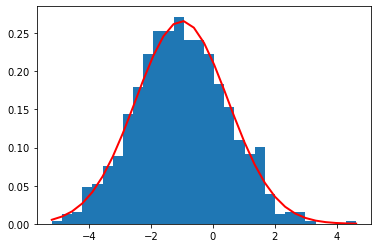

In [13]:
#rough
#
mu, sigma = -1, 1.5 # mean and standard deviation (-4 to 2)
s = np.random.normal(mu, sigma, 1000)
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

In [17]:
#rough
mu=-7.824245970866955
sigma=2.7972211086858363
y = np.random.lognormal(mu,sigma,10000000)

actual_mean=np.exp(mu+(sigma**2)/2)
actual_var=(np.exp(sigma**2)-1)*(np.exp(2*mu+sigma**2))
print('actual mean',actual_mean)
print('actual variance',actual_var)
print('data mean',np.mean(y))
print('data var',np.var(y))

actual mean 0.02000000000000001
actual variance 1.0000000000000013
data mean 0.01986334164438529
data var 0.693236721404159


In [13]:
def mu_sigma(actual_mean,actual_var):   
    #actual_mean & actual_var must be positive
    mu=np.log(actual_mean**2/(np.sqrt(actual_mean**2+actual_var)))
    sigma=np.sqrt(np.log(actual_var/actual_mean**2+1)) #std dev
    return (mu,sigma)

In [15]:
# prior: tpr ,mean 2%, sd 1
mu_sigma(0.02,1)

(-7.824245970866955, 2.7972211086858363)

# Hierarchical bayesian model/Partial pooling

We will perform bayesian hierarchical modeling using PyMC3. We will construct hyper priors on our group level parameters to allow the model to share ppg level coefficients among the groups withing the data. The model can be represented as:

$$ y_i = \alpha_{ji} + \beta_{ji}x_i + \epsilon_i $$

or in probabilistic notation:

$$ y \sim N(\alpha_{j} + \beta_{j}x, \epsilon) $$

where j is the PPG Item index.

For this model we will use a random slope and intercept, meaning both of them will have an hyper prior on them. 

In [17]:
sch_le = LabelEncoder()
tmp_map=model_base_data[['PPG_Item_No','PPG_Description']].drop_duplicates().reset_index(drop=True)
tmp_map['Encoding_PPG']=sch_le.fit_transform((tmp_map['PPG_Item_No']))
ppg_item = sch_le.fit_transform(model_base_data['PPG_Item_No'])
n_ppgs = len(sch_le.classes_)


In [18]:
#prior setup LogNormal

#reverse
rev=1
reverse_col=['wk_sold_median_base_price_byppg_log']
model_base_data[reverse_col]=(-1)*model_base_data[reverse_col]

SEED = 42
np.random.seed(SEED)

with pm.Model() as model:    
    # Hyperpriors for group nodes/PPGs
    mu_a = pm.Lognormal('mu_a', mu=mu_sigma(8,1000)[0], sigma=mu_sigma(8,1000)[1]) #intercept #10 #mu_sigma(-1.5,2)
    sigma_a = pm.HalfNormal('sigma_a', 10)
    
    mu_b = pm.Lognormal('mu_b', mu=mu_sigma(1,100)[0], sigma=mu_sigma(1,100)[1]) #price  #(1.5,1)
    sigma_b = pm.HalfNormal('sigma_b', 10) #5
    
    mu_c = pm.Lognormal('mu_c', mu=mu_sigma(0.026,1000)[0], sigma=mu_sigma(0.026,1000)[1]) #tpr???
    sigma_c = pm.HalfNormal('sigma_c', 10)
    
    mu_d = pm.Lognormal('mu_d', mu=mu_sigma(0.047,1000)[0], sigma=mu_sigma(0.047,1000)[1]) #acv ()acv is in range of 100
    sigma_d = pm.HalfNormal('sigma_d', 10)
    
    mu_e = pm.Lognormal('mu_e', mu=mu_sigma(0.39,1000)[0], sigma=mu_sigma(0.39,1000)[1]) #SI
    sigma_e = pm.HalfNormal('sigma_e', 10) #10
    
    mu_f = pm.Lognormal('mu_f', mu=mu_sigma(0.18,1000)[0], sigma=mu_sigma(0.18,1000)[1]) #cat
    sigma_f = pm.HalfNormal('sigma_f', 10)
    
    # Intercept
    Intercept = pm.Lognormal('Intercept', mu=mu_a, sigma=sigma_a, shape=n_ppgs)
    # price
    wk_sold_median_base_price_byppg_log = pm.Lognormal('wk_sold_median_base_price_byppg_log', mu=mu_b, sigma=sigma_b, shape=n_ppgs)
    #tpr
    tpr_discount_byppg = pm.Lognormal('tpr_discount_byppg', mu=mu_c, sigma=sigma_c, shape=n_ppgs)
    #acv
    ACV_Selling = pm.Lognormal('ACV_Selling', mu=mu_d, sigma=sigma_d, shape=n_ppgs)
    #SI
    SI = pm.Lognormal('SI', mu=mu_e, sigma=sigma_e, shape=n_ppgs)
    #catalogue
    Catalogue_Dist = pm.Lognormal('Catalogue_Dist', mu=mu_f, sigma=sigma_f, shape=n_ppgs)
    
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = (Intercept[ppg_item] + wk_sold_median_base_price_byppg_log[ppg_item] * model_base_data.wk_sold_median_base_price_byppg_log 
             +tpr_discount_byppg[ppg_item] * model_base_data.tpr_discount_byppg
             + ACV_Selling[ppg_item] *model_base_data.ACV_Selling+ SI[ppg_item] *model_base_data.SI+
              Catalogue_Dist[ppg_item] *model_base_data.Catalogue_Dist)
    
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat,sigma=eps, observed=model_base_data.wk_sold_qty_byppg_log)

Let's run inference with NUTS sampler for the model above

In [19]:
# Sampling
start = time.time()

with model:
    step = pm.NUTS()
    trace = pm.sample(10000, tune=2000,random_seed=SEED)

end = time.time()
print(f"Runtime of the program is {(end - start)/60} min") #3 models rhat==1, 10% divergences

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, Catalogue_Dist, SI, ACV_Selling, tpr_discount_byppg, wk_sold_median_base_price_byppg_log, Intercept, sigma_f, mu_f, sigma_e, mu_e, sigma_d, mu_d, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 3912 seconds.
There were 6922 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6247265052900972, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9625 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23533934352207284, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Runtime of the program is 66.11511919498443 min


In [20]:
result=pm.summary(trace)
result.reset_index(drop=False,inplace=True)

/home/tiger0102/anaconda3/envs/ta-lib-dev/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [21]:
result

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,mu_a,2.199000e+00,1.080000e-01,1.957,2.371000e+00,2.800000e-02,2.000000e-02,15.0,15.0,21.0,82.0,1.34
1,sigma_a,3.660000e-01,1.180000e-01,0.246,5.430000e-01,6.100000e-02,4.700000e-02,4.0,4.0,3.0,17.0,1.73
2,mu_b,6.900000e-02,8.200000e-02,0.000,1.630000e-01,4.000000e-03,3.000000e-03,481.0,481.0,21.0,59.0,1.27
3,sigma_b,3.320000e+00,1.257000e+00,1.225,4.621000e+00,5.720000e-01,4.320000e-01,5.0,5.0,5.0,172.0,1.32
4,mu_c,1.000000e-03,1.200000e-02,0.000,1.000000e-03,0.000000e+00,0.000000e+00,10121.0,10121.0,7.0,76.0,1.22
...,...,...,...,...,...,...,...,...,...,...,...,...
74,Catalogue_Dist[7],2.138945e+15,2.489190e+17,0.000,3.177711e+03,2.052135e+15,1.451107e+15,14713.0,14713.0,9.0,38.0,1.22
75,Catalogue_Dist[8],8.484262e+11,8.972455e+13,0.000,2.788712e+07,6.547557e+11,4.629894e+11,18779.0,18779.0,4.0,28.0,1.41
76,Catalogue_Dist[9],3.500000e-02,5.600000e-02,0.000,1.500000e-01,7.000000e-03,6.000000e-03,58.0,52.0,27.0,53.0,1.17
77,Catalogue_Dist[10],5.370000e-01,3.300000e-01,0.000,9.740000e-01,1.530000e-01,1.150000e-01,5.0,5.0,5.0,25.0,1.30


In [22]:
#Extracting Model Coefficient
result['index1']=result['index'].str.findall("\\d+")  #
result['index2']=result['index'].str.findall(("\\w+") )
result['Parameters']=result['index2'].apply(lambda x: x[0])
result['Encoding_PPG']=result['index1'].apply(lambda x: x[0] if len(x)>0 else -999)
result['Encoding_PPG']=result['Encoding_PPG'].astype(int)

In [23]:
model_coeff=tmp_map.merge(result[['Parameters','mean','sd','Encoding_PPG']],on=['Encoding_PPG'],how='left')

In [24]:
if rev==1:
    model_base_data[reverse_col]=(-1)*model_base_data[reverse_col]
    model_coeff['mean']=np.where(model_coeff['Parameters'].isin(reverse_col),(-1)*model_coeff['mean'],model_coeff['mean'])
    
model_coeff

,PPG_Item_No,PPG_Description,Encoding_PPG,Parameters,mean,sd
0,ITEM101_Lenta,A.Korkunov 110g,0,Intercept,5.470,0.298
1,ITEM101_Lenta,A.Korkunov 110g,0,wk_sold_median_base_price_byppg_log,-0.059,0.052
2,ITEM101_Lenta,A.Korkunov 110g,0,tpr_discount_byppg,0.024,0.004
3,ITEM101_Lenta,A.Korkunov 110g,0,ACV_Selling,0.031,0.002
4,ITEM101_Lenta,A.Korkunov 110g,0,SI,0.216,0.024
...,...,...,...,...,...,...
61,ITEM202_Lenta,Orbit XXL,10,wk_sold_median_base_price_byppg_log,-0.357,0.211
62,ITEM202_Lenta,Orbit XXL,10,tpr_discount_byppg,0.011,0.013
63,ITEM202_Lenta,Orbit XXL,10,ACV_Selling,0.010,0.014
64,ITEM202_Lenta,Orbit XXL,10,SI,0.767,0.272


In [25]:
rev

1

In [26]:
#prediction
def predict_sales(coeffs,data):
    data.reset_index(inplace=True,drop=True)
    data['pred_vol_log']=0
    for i in coeffs['Parameters'].unique():
        a=coeffs.loc[(coeffs['Parameters']==i),'mean']
        a=a.values
        if(i=="Intercept"):
            data['pred_vol_log'] = data['pred_vol_log'] + a
        else:
            data['pred_vol_log'] = data['pred_vol_log']+ data[i]* a 
    data['pred_vol'] = np.exp(data['pred_vol_log'])
    return(data)

def rsq_mape(y,Predicted):
    SSR=(y-Predicted)**2
    SST=(y-np.mean(y))**2
    SSReg=(Predicted-np.mean(y))**2
    #Rsq1=SSReg.sum()/SST.sum() 
    Rsq2=1-SSR.sum()/SST.sum()
    a1=np.sum(abs(y - Predicted)*y)
    a2=np.sum(y*y)
    mape=a1/a2
    return(Rsq2,mape)

In [27]:
model_base_data.columns

Index(['PPG_Segment', 'PPG_MFG', 'PPG_Item_No', 'PPG_Description', 'Date',
       'wk_sold_median_base_price_byppg_log', 'tpr_discount_byppg',
       'ACV_Selling', 'SI', 'Catalogue_Dist', 'wk_sold_qty_byppg_log',
       'wk_sold_qty_byppg'],
      dtype='object')

In [28]:
#mape,rsq,pred
model_base_data['wk_sold_qty_byppg']=np.exp(model_base_data['wk_sold_qty_byppg_log'])
model_base_data.columns
model_base_data.reset_index(drop=True,inplace=True)
model_base_data1=pd.DataFrame()
for ppg in model_base_data['PPG_Item_No'].unique():
    print(ppg)
    data=model_base_data.loc[model_base_data["PPG_Item_No"]==ppg,].reset_index(drop=True)
    
    coeffs=model_coeff.loc[model_coeff["PPG_Item_No"]==ppg,
                                  ['Parameters','mean']].reset_index(drop=True)
    
    #print(coeffs)
    cols=list(coeffs['Parameters'].unique())
    cols.remove('Intercept')
    tmp=data[cols]      
    tmp=predict_sales(coeffs,tmp)
    
    #rsq2=1-sum(error)/sum(y-mean(y))^2
    Rsq2,mape=rsq_mape(data['wk_sold_qty_byppg'],tmp['pred_vol'])
    #print(Rsq2,mape)
    
    data['pred_vol']=tmp['pred_vol']
    data['Rsq']=Rsq2
    data['Mape']=mape
    model_base_data1=model_base_data1.append(data)


model_base_data1.reset_index(drop=True,inplace=True)
    
    
    

    
    

ITEM101_Lenta
ITEM102_Lenta
ITEM103_Lenta
ITEM105_Lenta
ITEM108_Lenta
ITEM109_Lenta
ITEM110_Lenta
ITEM113_Lenta
ITEM114_Lenta
ITEM201_Lenta
ITEM202_Lenta


In [29]:
model_base_data1[['PPG_Description','Rsq','Mape']].drop_duplicates()

,PPG_Description,Rsq,Mape
0,A.Korkunov 110g,0.687754,0.464174
143,A.Korkunov 192g,0.582170,0.441776
286,Big Bars,0.735913,0.248342
429,Loose,0.501860,0.417169
572,M&M 360g,0.661387,0.298287
715,M&M 45g,0.769506,0.139539
858,MW Std,0.565075,0.199974
1001,Snickers Crisp Trio,-0.320823,0.489685
1071,Std Bars,0.285104,0.247564
1214,Orbit OTC,0.352965,0.304443


In [30]:
#Export
path=os.path.join(parent_dir,'Modelling_Results',slct_retailer,'Pooled_Model_Results')
os.makedirs(path, exist_ok=True)
with pd.ExcelWriter(path+'/Pooled_Model_Bayesian_Result_all_ppg_log_normal_updated.xlsx') as writer1:
    model_coeff.to_excel(writer1, sheet_name = 'coeff', index = False)
    model_base_data1.to_excel(writer1, sheet_name = 'base', index = False)



In [31]:
model_base_data.head()

,PPG_Segment,PPG_MFG,PPG_Item_No,PPG_Description,Date,wk_sold_median_base_price_byppg_log,tpr_discount_byppg,ACV_Selling,SI,Catalogue_Dist,wk_sold_qty_byppg_log,wk_sold_qty_byppg
0,CHOCO,Mars,ITEM101_Lenta,A.Korkunov 110g,2017-12-31,4.717361,0.0,69.696970,1.572075,0.0,8.782630,6520.0
1,CHOCO,Mars,ITEM101_Lenta,A.Korkunov 110g,2018-01-07,4.717379,0.0,58.008658,0.521117,0.0,6.994850,1091.0
2,CHOCO,Mars,ITEM101_Lenta,A.Korkunov 110g,2018-01-14,4.721366,0.0,49.783550,0.414287,0.0,6.723832,832.0
3,CHOCO,Mars,ITEM101_Lenta,A.Korkunov 110g,2018-01-21,4.722531,0.0,49.783550,0.403632,0.0,6.368187,583.0
4,CHOCO,Mars,ITEM101_Lenta,A.Korkunov 110g,2018-01-28,5.048338,0.0,45.258621,0.416327,0.0,6.452049,634.0
